In [1]:
import cv2
import numpy as np
import theano
import theano.tensor as tensor
import lasagne
import matplotlib.pyplot as plt
import os
from lasagne.layers import (batch_norm, Conv2DLayer, Deconv2DLayer,
                            DropoutLayer, ReshapeLayer, InputLayer, DenseLayer, NonlinearityLayer)
from lasagne.layers.pool import MaxPool2DLayer, Upscale2DLayer
from lasagne.nonlinearities import softmax, sigmoid, rectify
from IPython.display import display, Image as im
from PIL import Image
from resizeimage import resizeimage

rect = lasagne.nonlinearities.rectify


Using cuDNN version 5005 on context None
Preallocating 4319/4799 Mb (0.900000) on cuda0
Mapped name None to device cuda0: Tesla K20m (0000:20:00.0)


In [ ]:
%load_ext autoreload


In [6]:
from theano.tensor.nnet.abstract_conv import bilinear_upsampling
lr = lasagne.nonlinearities.LeakyRectify(leakiness=0.2)

class BilinearUpLayer(lasagne.layers.Layer):
    def __init__(self, incoming, ratio, nonlinearity=lr, **kwargs):
        super(BilinearUpLayer, self).__init__(incoming, **kwargs)
        self.incoming = incoming
        self.ratio = ratio    
        self.nonlinearity = nonlinearity
#         if (not isinstance(output_size, tensor.Variable) and output_size is not None):
#             if isinstance(output_size, tuple):
#                 output_size = output_size
#             elif isinstance(output_size, list):
#                 output_size = tuple(output_size)
#             elif isinstance(output_size, int):
#                 output_size = tuple([output_size, output_size])
#             else:
#                 raise
#         self.output_size = output_size
        
    def get_ouput_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2] * ratio, input_shape[3] * ratio)
    
    def get_output_for(self, input, deterministic=False, **kwargs):
        return self.nonlinearity(bilinear_upsampling(input, self.ratio, use_1D_kernel=False))


class SubpixelLayer(lasagne.layers.Layer):

    def __init__(self, incoming,r,c, nonlinearity=rect, **kwargs):
        super(SubpixelLayer, self).__init__(incoming, **kwargs)
        self.r=r # Upscale factor
        self.c=c # number of output channels
        self.nonlinearity = nonlinearity
        
    def get_output_shape_for(self, input_shape):
        return (input_shape[0],self.c,self.r*input_shape[2],self.r*input_shape[3])

    def get_output_for(self, input, deterministic=False, **kwargs):
        out = tensor.zeros((input.shape[0],self.output_shape[1],self.output_shape[2],self.output_shape[3]))
        for x in xrange(self.r): # loop across all feature maps belonging to this channel
            for y in xrange(self.r):
                out=tensor.set_subtensor(out[:,:,x::self.r,y::self.r],input[:,self.r*x+y::self.r*self.r,:,:])
        return self.nonlinearity(out)

class Dconv2DLayer(lasagne.layers.Layer):

    def __init__(self, incoming, num_filters, filter_size, stride=1, pad=0,
            nonlinearity=rect, **kwargs):
        super(Dconv2DLayer, self).__init__(incoming, **kwargs)
        self.num_filters = num_filters
        self.filter_size = lasagne.utils.as_tuple(filter_size, 2, int)
        self.stride = lasagne.utils.as_tuple(stride, 2, int)
        self.pad = lasagne.utils.as_tuple(pad, 2, int)
        self.W = self.add_param(lasagne.init.Normal(0.05),
                (self.input_shape[1], num_filters) + self.filter_size,
                name='W')
        self.b = self.add_param(lasagne.init.Constant(0),
                (num_filters,),
                name='b')
        if nonlinearity is None:
            nonlinearity = lasagne.nonlinearities.identity
        self.nonlinearity = nonlinearity

    def get_output_shape_for(self, input_shape):
        shape = tuple(i*s - 2*p + f - 1
                for i, s, p, f in zip(input_shape[2:],
                                      self.stride,
                                      self.pad,
                                      self.filter_size))
        return (input_shape[0], self.num_filters) + shape

    def get_output_for(self, input, **kwargs):
        op = tensor.nnet.abstract_conv.AbstractConv2d_gradInputs(
            imshp=self.output_shape,
            kshp=(self.input_shape[1], self.num_filters) + self.filter_size,
            subsample=self.stride, border_mode=self.pad)
        conved = op(self.W, input, self.output_shape[2:])
        if self.b is not None:
            conved += self.b.dimshuffle('x', 0, 'x', 'x')
        return self.nonlinearity(conved)

class DotLayer(lasagne.layers.Layer):
    def __init__(self, incoming, num_units, W=lasagne.init.Normal(0.01), nonlinearities=None, **kwargs):
        super(DotLayer, self).__init__(incoming, **kwargs)
        num_inputs = self.input_shape[1]
        self.num_units = num_units
        self.W = self.add_param(W, (num_inputs, num_units), name='W')
        self.nonlinearities = nonlinearities

    def get_output_for(self, input, **kwargs):
        return self.nonlinearities(tensor.dot(input, self.W))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.num_units)

In [7]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict
load_path = '/home/neena/Ramana/Dataset/cifar-100-python/train'
cifar_data = unpickle(load_path)

data
batch_label
fine_labels
coarse_labels
filenames
(50000, 3072)


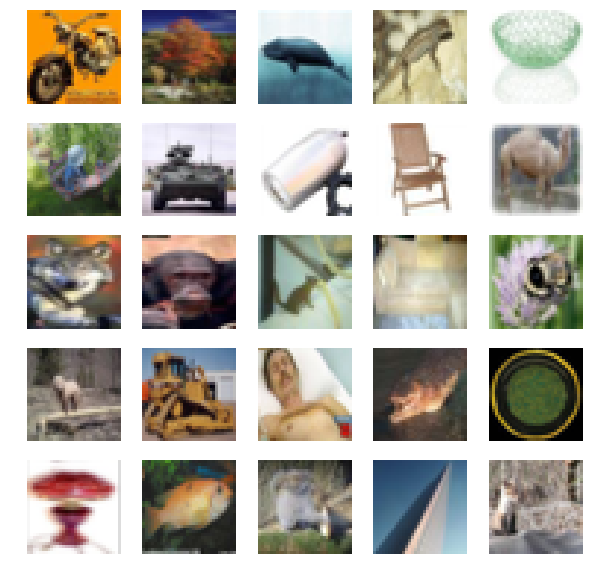

In [10]:
# Visualisation cell
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import pylab
for k, v in cifar_data.items():
    print k
print cifar_data['data'].shape
reshaped_image = cifar_data['data'].reshape(50000, 3, 32, 32)
transposed_image = reshaped_image.transpose(0, 2, 3, 1)
fig, axes1 = plt.subplots(5, 5, figsize=(10, 10))
# axes1.set_axis_off()
# axes1.imshow(reshaped_image[10])
# fig.imshow(reshaped_image[10])
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(reshaped_image)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(transposed_image[i:i+1][0])

In [11]:
w1 = lasagne.init.Normal(0.05)
from lasagne.layers.dense import NINLayer
from lasagne.layers.pool import GlobalPoolLayer
def build_generator(inp):
    net0 = InputLayer((None, 100), input_var=inp)
    net1 = batch_norm(DenseLayer(net0, 8192, W=w1))
    net2 = ReshapeLayer(net1, ([0], 512, 4, 4))
    net3 = batch_norm(Dconv2DLayer(net2, 256, 5, stride=2, pad=2))
    print ("Generator output:", net3.output_shape)
    # 8 * 8
    net4 = batch_norm(Dconv2DLayer(net3, 128, 5, stride=2, pad=2))
    print ("Generator output:", net4.output_shape)
    # 16 * 16
    net5 = Dconv2DLayer(net4, 3, 5, stride=2, pad=2, nonlinearity=tanh)
    print ("Generator output:", net5.output_shape)
    # 3 * 32 * 32
    return net5
    

def build_desc(inp):
    net0= DropoutLayer(InputLayer((None, 3, 32, 32), input_var=inp), p=0.2)
    # 32 * 32
    net10 = batch_norm(Conv2DLayer(net0, 96, 3, pad=1, W=w1, nonlinearity=lr))
    net11 = batch_norm(Conv2DLayer(net10, 96, 3, pad=1, W=w1, nonlinearity=lr))
    net1 = DropoutLayer(batch_norm(Conv2DLayer(net11, 96, 3, stride=2, pad=1, W=w1, nonlinearity=lr)), p=0.5)
    print ("Disc output:", net1.output_shape)
    # 16 * 16
    
    net20 = batch_norm(Conv2DLayer(net1, 192, 3, pad=1, W=w1, nonlinearity=lr))
    net21 = batch_norm(Conv2DLayer(net20, 192, 3, pad=1, W=w1, nonlinearity=lr))
    net2 = DropoutLayer(batch_norm(Conv2DLayer(net21, 192, 3, stride=2, pad=1, W=w1, nonlinearity=lr)), p=0.5)
    print ("Disc output:", net2.output_shape)
    # 8 * 8
    net3 = batch_norm(Conv2DLayer(net2, 192, 3, pad=0, W=w1, nonlinearity=lr))
    print ("Disc output:", net3.output_shape)
    # 6 * 6
    net4 = batch_norm(NINLayer(net3, 192, W=w1, nonlinearity=lr))
    net5 = GlobalPoolLayer(net4)
    print ("Disc output:", net5.output_shape)

    net6 = DenseLayer(net5, 1, nonlinearity=sigmoid)
    print ("Discriminator output:", net6.output_shape)
    
    return net6
    

('Generator output:', (None, 256, 8, 8))
('Generator output:', (None, 128, 16, 16))
('Generator output:', (None, 3, 32, 32))
('Disc output:', (None, 96, 16, 16))
('Disc output:', (None, 192, 8, 8))
('Disc output:', (None, 192, 6, 6))
('Disc output:', (None, 192))
('Discriminator output:', (None, 1))
Starting to compile functions
done compiling training functions
done all compilation
DC GAN loss is [ 0.92686  0.8987 ]
Finished 1 of 200. Time taken 335.341s
DC GAN loss is [ 0.8919   0.89706]
Finished 2 of 200. Time taken 333.909s
DC GAN loss is [ 0.8542   0.85234]
Finished 3 of 200. Time taken 332.742s
DC GAN loss is [ 0.84584  0.84128]
Finished 4 of 200. Time taken 333.428s
DC GAN loss is [ 0.85238  0.84546]
Finished 5 of 200. Time taken 333.868s
DC GAN loss is [ 0.8787  0.8701]
Finished 6 of 200. Time taken 333.851s
DC GAN loss is [ 0.87784  0.8742 ]
Finished 7 of 200. Time taken 333.596s
DC GAN loss is [ 0.88004  0.87262]
Finished 8 of 200. Time taken 333.552s
DC GAN loss is [ 0.87266

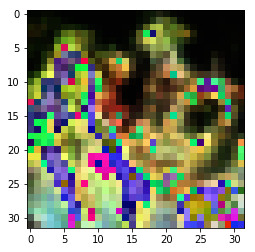

In [12]:
import time
from lasagne.objectives import binary_crossentropy
from lasagne.nonlinearities import tanh
# The alternative loss function is followed from Improved ways of training GANs
# If any license exists, the research work is from OpenAI

def log_sum_exp(x, axis=1):
    m = tensor.max(x, axis=axis)
    return m+tensor.log(tensor.sum(tensor.exp(x-m.dimshuffle(0,'x')), axis=axis))

def combined_alt_loss_function(l_gen, l_des):
    return -0.5*tensor.mean(l_desc) + 0.5*tensor.mean(tensor.nnet.softplus(l_desc)) + \
            0.5*T.mean(T.nnet.softplus(l_gen))

initial_lr = 3e-04
l_r = theano.shared(np.float32(initial_lr))
batch_size = 100
batch_number = int(round(len(reshaped_image)/batch_size))
num_epochs = 200

noise_var = tensor.matrix('noise', dtype='float32')
x_inp = tensor.tensor4('x_inp', dtype='float32')

gen = build_generator(noise_var)
desc = build_desc(x_inp)

# Output of discriminator with original images
disc = lasagne.layers.get_output(desc)
# Output of Generator combined with discriminator. This for training Generator
disc_over_gen = lasagne.layers.get_output(desc, lasagne.layers.get_output(gen))

# Loss functions
generator_loss = binary_crossentropy(disc_over_gen, tensor.ones_like(disc_over_gen)).mean()
discriminator_loss = (binary_crossentropy(disc, tensor.ones_like(disc)) + 
                      binary_crossentropy(disc_over_gen, tensor.zeros_like(disc_over_gen))).mean()
# Update params
gen_params = lasagne.layers.get_all_params(gen, trainable=True)
disc_params = lasagne.layers.get_all_params(desc, trainable=True)

# Gen updates
updates = lasagne.updates.adam(generator_loss, gen_params, beta1=0.5, learning_rate=l_r)
updates.update(lasagne.updates.adam(discriminator_loss, disc_params, beta1=0.5, 
                                    learning_rate=l_r))

# Generating noise and setting up noise var
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

# Compile theano functions
# Functions for training
print("Starting to compile functions")
train_func = theano.function([noise_var, x_inp], [(disc > 0.5).mean(), (disc_over_gen < 0.5).mean()],
                             updates=updates)
print("done compiling training functions")
# Functions for generating
generate_im_func = theano.function([noise_var], lasagne.layers.get_output(gen, deterministic=True))
print("done all compilation")

for ep in range(num_epochs):
    # create batches problematicand train
    # Batch size is 128, so 220
    gan_loss = []
    disc_loss = []
    begin = time.time()
    offset = 0
    loss = 0
    for num_iter, bn in enumerate(range(batch_number)):
        inputs = reshaped_image[offset:offset + batch_size] / np.float32(127.5) - 1
        noise = lasagne.utils.floatX(np.random.rand(batch_size, 100))
        loss += np.array(train_func(noise, inputs))
        offset += batch_size
    end = time.time()
    print("DC GAN loss is " + str(loss / np.float32(batch_number)))
    print("Finished {} of {}. Time taken {:.3f}s".format(ep + 1, num_epochs,  end - begin))
    # plotting image
    generated_image = generate_im_func(lasagne.utils.floatX(np.random.rand(10, 100)))
    plt.imshow(generated_image.transpose(0, 2, 3, 1)[0])
    plt.figure(1)

# generated_image = generate_im_func(lasagne.utils.floatX(np.random.rand(1, 100)))
# plt.imshow(generated_image[0].transpose(1, 2, 0))
# plt.figure(1)

In [306]:
for ep in range(100):
    # create batches and train
    # Batch size is 128, so 220
    gan_loss = []
    disc_loss = []
    begin = time.time()
    offset = 0
    loss = 0
    for num_iter, bn in enumerate(range(batch_number)):
        inputs = reshaped_image[offset:offset + batch_size] / np.float32(127.5) - 1
        noise = lasagne.utils.floatX(np.random.rand(batch_size, 100))
        loss += np.array(train_func(noise, inputs))
        offset += batch_size
    end = time.time()
    print("DC GAN loss is " + str(loss / np.float32(batch_number)))
    print("Finished {} of {}. Time taken {:.3f}s".format(ep + 1, 50,  end - begin))
    # plotting image
    generated_image = generate_im_func(lasagne.utils.floatX(np.random.rand(10, 100)))
    plt.imshow(generated_image.transpose(0, 2, 3, 1)[0])
    plt.figure(1)

TypeError: Bad input argument to theano function with name "<ipython-input-301-8a60b710835c>:29" at index 0 (0-based).  
Backtrace when that variable is created:

  File "/home/neena/anaconda2/envs/ramana/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/neena/anaconda2/envs/ramana/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/neena/anaconda2/envs/ramana/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/neena/anaconda2/envs/ramana/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/neena/anaconda2/envs/ramana/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/neena/anaconda2/envs/ramana/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/neena/anaconda2/envs/ramana/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-300-fff3695f203b>", line 7, in <module>
    i1 = tensor.tensor4()
Wrong number of dimensions: expected 4, got 2 with shape (100, 100).

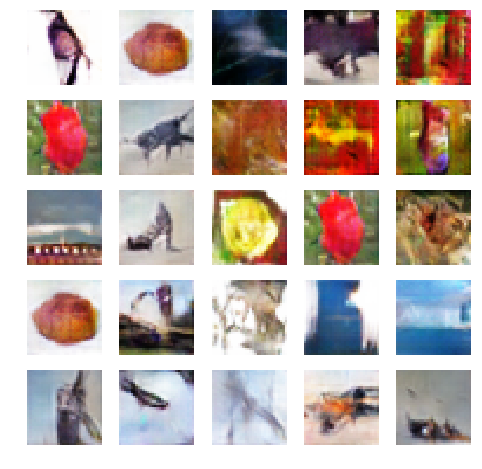

In [19]:
import os
from skimage.io import imsave
PATH = '/home/neena/Ramana/Dataset/'
generated_image = generate_im_func(lasagne.utils.floatX(np.random.rand(150, 100)))
fig, axes1 = plt.subplots(5, 5, figsize=(8, 8))
# axes1.set_axis_off()
# axes1.imshow(reshaped_image[10])
# fig.imshow(reshaped_image[10])
gen_trans_image = generated_image.transpose(0, 2, 3, 1)
orig_trans_image = reshaped_image.transpose(0, 2, 3, 1)
img_h, img_w = (32, 32)
grid_shape = 8
grid_pad = 5
grid_h = img_h * grid_shape + grid_pad * (grid_shape - 1)
grid_w = img_w * grid_shape + grid_pad * (grid_shape - 1)
img_grid = np.zeros((grid_h, grid_w, 3), dtype=np.uint8)

for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(gen_trans_image)))
        axes1[j][k].set_axis_off()
        deproc = ((gen_trans_image[i:i+1][0] + 1) * 127.5).astype(np.uint8)
        axes1[j][k].imshow((deproc))
    row = (j // grid_shape) * (img_h + grid_pad)
    col = (j % grid_shape) * (img_w + grid_pad)

    img_grid[row:row+img_h, col:col+img_w, :] = deproc
    imsave(os.path.join(PATH, "sample" + str(j) + ".jpg"), deproc)


In [253]:
class SubpixelLayer(lasagne.layers.Layer):

    def __init__(self, incoming,r,c, nonlinearity=lasagne.nonlinearities.rectify, **kwargs):
        super(SubpixelLayer, self).__init__(incoming, **kwargs)
        self.r=r # Upscale factor
        self.c=c # number of output channels
        self.nonlinearity = nonlinearity
        
    def get_output_shape_for(self, input_shape):
        return (input_shape[0],self.c,self.r*input_shape[2],self.r*input_shape[3])

    def get_output_for(self, input, deterministic=False, **kwargs):
        out = tensor.zeros((input.shape[0],self.output_shape[1],self.output_shape[2],self.output_shape[3]))
        for x in xrange(self.r): # loop across all feature maps belonging to this channel
            for y in xrange(self.r):
                out=tensor.set_subtensor(out[:,:,x::self.r,y::self.r],input[:,self.r*x+y::self.r*self.r,:,:])
        return self.nonlinearity(out)

class BilinearUpLayer(lasagne.layers.Layer):
    def __init__(self, incoming, ratio, nonlinearity=l_r, **kwargs):
        super(BilinearUpLayer, self).__init__(incoming, **kwargs)
        self.incoming = incoming
        self.ratio = ratio    
        self.nonlinearity = nonlinearity
#         if (not isinstance(output_size, tensor.Variable) and output_size is not None):
#             if isinstance(output_size, tuple):
#                 output_size = output_size
#             elif isinstance(output_size, list):
#                 output_size = tuple(output_size)
#             elif isinstance(output_size, int):
#                 output_size = tuple([output_size, output_size])
#             else:
#                 raise
#         self.output_size = output_size
        
    def get_ouput_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2] * self.ratio, input_shape[3] * self.ratio)
    
    def get_output_for(self, input, deterministic=False, **kwargs):
        return self.nonlinearity(bilinear_upsampling(input, self.ratio, use_1D_kernel=False))


In [300]:
# Flickr playground
from lasagne.nonlinearities import rectify
from theano.tensor.nnet.abstract_conv import bilinear_upsampling
import pylab
load_path = '/home/neena/Ramana/Dataset/Flickr dataset/'
resized = cv2.resize(cv2.imread(load_path + "flickr30k-images/3028095878.jpg"), (128, 128)).transpose(2, 0, 1)
i1 = tensor.tensor4()
w1=lasagne.init.Normal(mean=0.02)
l_r = lasagne.nonlinearities.LeakyRectify(leakiness=0.2)
n0 = InputLayer((2, 3, 128, 128), input_var=i1)
n1 = batch_norm(Conv2DLayer(n0, 16, 4, stride=2, pad=1, W=w1, nonlinearity=l_r))
n2 = batch_norm(Conv2DLayer(n1, 16, 4, stride=2, pad=1, W=w1, nonlinearity=l_r))
n3 = batch_norm(SubpixelLayer(n2, 4, 16, nonlinearity=sigmoid))
n4 = Conv2DLayer(n3, 3, 1, stride=1, pad=0)
net_out = lasagne.layers.get_output(n4)

# out = func1(resized.reshape(1, 3, 64, 64).astype('float32'))
# plt.imshow(resized.reshape(1, 3, 64, 64).reshape(64, 64, 3).astype('float32'))
# print out[0].shape
# # plt.imshow(out[0].reshape(64, 64, 3))
# plt.figure(1)

In [301]:
initial_lr = 2e-04
lr = theano.shared(np.float32(initial_lr))

def normalise(im):
    im = im / np.float32(127.5) - np.float32(1.)
    return im
def denormalise(im, tanh=True):
    im = ((im + np.float32(1.0)) * np.float32(127.5)).astype(np.uint8)
    if tanh:
        im = im.transpose(0, 2, 3, 1)
    return im
    
import pylab
im = cv2.imread(load_path + "flickr30k-images/5722658.jpg")
im2 = cv2.imread(load_path + "flickr30k-images/38137970.jpg")
im3 = cv2.imread(load_path + "flickr30k-images/3028095878.jpg")

#Test
im4 = cv2.imread(load_path + "flickr30k-images/1317156.jpg")
im5 = cv2.imread(load_path + "flickr30k-images/675153.jpg")
orig_images = tensor.tensor4()
# loss
loss = tensor.mean(lasagne.objectives.squared_error(net_out, i1))
# Collecting parameters
params = lasagne.layers.get_all_params(n4, trainable=True)

# Updates 
updates = lasagne.updates.adam(loss, params, beta1=np.float32(0.5), learning_rate=lr)
train_func = theano.function([i1], loss, updates=updates)
# test
test_im = tensor.tensor4()
gen_func = theano.function([i1], net_out)


first_image = normalise(cv2.resize(im, (128, 128)).transpose(2, 0, 1))
second_image = normalise(cv2.resize(im2, (128, 128)).transpose(2, 0, 1))
third_image = normalise(cv2.resize(im3, (128, 128)).transpose(2, 0, 1))
three_images = np.stack((first_image, second_image, third_image)).astype('float32')
print three_images.shape
for i in range(100):
    print "Training epoch1"
    print train_func(three_images[0:2])
# print gen_image.shape
# first_reshaped = cv2.resize(im, (128, 128)).reshape(3, 128, 128)
# pylab.imshow(denormalise(gen_func()))
# pylab.show()

(3, 3, 128, 128)
Training epoch1


RuntimeError: Error doing inplace add
Apply node that caused the error: GpuIncSubtensor{InplaceInc;::, int64::int64, ::, ::}(GpuAlloc<None>{memset_0=True}.0, GpuSubtensor{::, ::, int64::int64, int64::int64}.0, Constant{0}, Constant{16})
Toposort index: 398
Inputs types: [GpuArrayType<None>(float32, (False, False, False, False)), GpuArrayType<None>(float32, (False, False, False, False)), Scalar(int64), Scalar(int64)]
Inputs shapes: [(2, 16, 32, 32), (2, 16, 32, 32), (), ()]
Inputs strides: [(65536, 4096, 128, 4), (1048576, 65536, 2048, 16), (), ()]
Inputs values: ['not shown', 'not shown', 0, 16]
Outputs clients: [[GpuIncSubtensor{InplaceInc;::, int64::int64, ::, ::}(GpuIncSubtensor{InplaceInc;::, int64::int64, ::, ::}.0, GpuSubtensor{::, ::, int64::int64, int64::int64}.0, Constant{1}, Constant{16})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [234]:
for i in range(100):
    print "Training epoch1"
    print train_func(three_images[0:2])

Training epoch1
0.252018362284
Training epoch1
0.251218110323
Training epoch1
0.250389516354
Training epoch1
0.249594897032
Training epoch1
0.248806163669
Training epoch1
0.248023122549
Training epoch1
0.247257992625
Training epoch1
0.246529206634
Training epoch1
0.245783209801
Training epoch1
0.245045542717
Training epoch1
0.244277402759
Training epoch1
0.243533402681
Training epoch1
0.242799580097
Training epoch1
0.242085754871
Training epoch1
0.241378366947
Training epoch1
0.240662425756
Training epoch1
0.23994988203
Training epoch1
0.239249333739
Training epoch1
0.238540157676
Training epoch1
0.237851947546
Training epoch1
0.2371558249
Training epoch1
0.236473083496
Training epoch1
0.235795944929
Training epoch1
0.235125780106
Training epoch1
0.23446033895
Training epoch1
0.233802080154
Training epoch1
0.23314653337
Training epoch1
0.232496619225
Training epoch1
0.231826037169
Training epoch1
0.231164038181
Training epoch1
0.230495333672
Training epoch1
0.229837745428
Training epoc

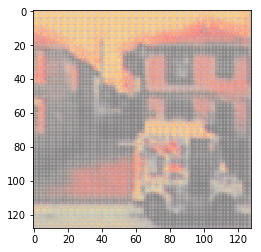

AssertionError: 

In [236]:
fourth_image = normalise(cv2.resize(im4, (128, 128)).transpose(2, 0, 1))
fifth_image = normalise(cv2.resize(im5, (128, 128)).transpose(2, 0, 1))

test_ims = np.stack((fourth_image, fifth_image)).astype('float32')
test_out = gen_func(test_ims)
pylab.imshow(denormalise(test_out)[0])
pylab.show()
assert np.allclose(im, denormalise(normalise(im), tanh=False))

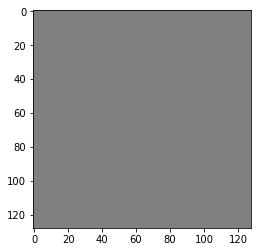

RuntimeError: Error doing inplace add
Apply node that caused the error: GpuIncSubtensor{InplaceInc;::, int64::int64, ::, ::}(GpuAlloc<None>{memset_0=True}.0, GpuSubtensor{::, ::, int64::int64, int64::int64}.0, Constant{0}, Constant{16})
Toposort index: 446
Inputs types: [GpuArrayType<None>(float32, (False, False, False, False)), GpuArrayType<None>(float32, (False, False, False, False)), Scalar(int64), Scalar(int64)]
Inputs shapes: [(3, 16, 32, 32), (3, 16, 32, 32), (), ()]
Inputs strides: [(65536, 4096, 128, 4), (1048576, 65536, 2048, 16), (), ()]
Inputs values: ['not shown', 'not shown', 0, 16]
Outputs clients: [[GpuIncSubtensor{InplaceInc;::, int64::int64, ::, ::}(GpuIncSubtensor{InplaceInc;::, int64::int64, ::, ::}.0, GpuSubtensor{::, ::, int64::int64, int64::int64}.0, Constant{1}, Constant{16})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [305]:
test1 = tensor.tensor4('test1')
t_inp = InputLayer((3, 3, 128, 128), input_var=test1)
t1 = batch_norm(Conv2DLayer(t_inp, 16, 4, stride=2, pad=1, W=w1, nonlinearity=l_r))
t2 = batch_norm(Conv2DLayer(t1, 32, 4, stride=2, pad=1, W=w1, nonlinearity=l_r))
t3 = batch_norm(Conv2DLayer(t2, 16, 1, stride=1, pad=0))
bup = SubpixelLayer(t3, 4, 16, nonlinearity=rectify)
t4 = Conv2DLayer(bup, 3, 1, stride=1, pad=0)

t_out = lasagne.layers.get_output(t4)
# test_conv = Conv2DLayer(bup, 3, 1, stride=1, pad=0, nonlinearity=sigmoid)
func_test = theano.function([test1], t_out)

test_loss = tensor.mean(lasagne.objectives.squared_error(t_out, test1))
# Collecting parameters
test_params = lasagne.layers.get_all_params(t4, trainable=True)

# Updates 
test_updates = lasagne.updates.adam(test_loss, test_params, beta1=np.float32(0.5), learning_rate=lr)
test_train_func = theano.function([test1], test_loss, updates=test_updates)

im_t = func_test(three_images)
pylab.imshow(denormalise(im_t)[0])
pylab.show()
test_train_func(three_images)